In [ ]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import mplhep as hep
hep.style.use(hep.style.LHCb2) # make our plots look good
from scipy.stats import crystalball
from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.integrate import quad
import pandas as pd
from scipy.stats import norm

In [ ]:
# Set global font size
plt.rc('font', size=14)          # controls default text size
plt.rc('axes', titlesize=14)     # fontsize of the title
plt.rc('axes', labelsize=13)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the x tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the y tick labels
plt.rc('legend', fontsize=14)    # fontsize of the legend

In [ ]:
branches_cc= uproot.concatenate(['/eos/lhcb/wg/RD/Lb2Lll/RLambda/Tuples/v206/TupleProcess_EE_MVA/Lb2LJPsEE/MC18LLMU/Lb2LJPsEE_procTuple.root:Lb2JpsiL_eeTuple/DecayTree','/eos/lhcb/wg/RD/Lb2Lll/RLambda/Tuples/v206/TupleProcess_EE_MVA/Lb2LJPsEE/MC16LLMU/Lb2LJPsEE_procTuple.root:Lb2JpsiL_eeTuple/DecayTree','/eos/lhcb/wg/RD/Lb2Lll/RLambda/Tuples/v206/TupleProcess_EE_MVA/Lb2LJPsEE/MC17LLMU/Lb2LJPsEE_procTuple.root:Lb2JpsiL_eeTuple/DecayTree'], expressions=('Lb_q2','Lb_M','Lb_DTF_L0_JPs_PV_M_0','Lb_DTF_L0_JPs_PV_Lambda0_pplus_ID_0','Pi_AtVtx_PE','P_AtVtx_P','Pi_AtVtx_PX','P_AtVtx_PX','Pi_AtVtx_PY','P_AtVtx_PY','Pi_AtVtx_PZ','P_AtVtx_PZ'))
#array_cc = array_c = uproot.concatenate(['/eos/lhcb/wg/RD/Lb2Lll/RLambda/Tuples/v206/TupleProcess_EE_MVA/Lb2LJPsEE/MC18LLMU/Lb2LJPsEE_procTuple.root:Lb2JpsiL_eeTuple/DecayTree','/eos/lhcb/wg/RD/Lb2Lll/RLambda/Tuples/v206/TupleProcess_EE_MVA/Lb2LJPsEE/MC16LLMU/Lb2LJPsEE_procTuple.root:Lb2JpsiL_eeTuple/DecayTree','/eos/lhcb/wg/RD/Lb2Lll/RLambda/Tuples/v206/TupleProcess_EE_MVA/Lb2LJPsEE/MC17LLMU/Lb2LJPsEE_procTuple.root:Lb2JpsiL_eeTuple/DecayTree'], expressions=('Pi_AtVtx_PE','P_AtVtx_P','Pi_AtVtx_PX','P_AtVtx_PX','Pi_AtVtx_PY','P_AtVtx_PY','Pi_AtVtx_PZ','P_AtVtx_PZ'))


In [ ]:
mass_K0_cc = np.sqrt(np.square(branches_cc['Pi_AtVtx_PE']
                           +np.sqrt(np.square(139.57)
                                    +np.square(branches_cc['P_AtVtx_P'])))
                 - np.square(branches_cc['Pi_AtVtx_PX'] +
                             branches_cc['P_AtVtx_PX'])
                 - np.square(branches_cc['Pi_AtVtx_PY']
                             +branches_cc['P_AtVtx_PY'])
                 -np.square(branches_cc['Pi_AtVtx_PZ']+branches_cc['P_AtVtx_PZ']))

In [ ]:
#Definition of variables

#Define particle-anti selection
protons = branches_cc['Lb_DTF_L0_JPs_PV_Lambda0_pplus_ID_0'] > 0
antiprotons= branches_cc['Lb_DTF_L0_JPs_PV_Lambda0_pplus_ID_0'] < 0

sel_m_cc= abs(branches_cc['Lb_q2']) < 11
sel__m_cc= abs(branches_cc['Lb_q2']) > 6


#cut
up = mass_K0_cc>= 512.4
down = mass_K0_cc <= 481.6
[up|down]

combined_1_cc= sel_m_cc & sel__m_cc
combined_2_cc = up | down
final_cc = combined_1_cc& combined_2_cc

In [ ]:
Lb_DTF_L0_JPs_PV_M_0_selection = branches_cc['Lb_DTF_L0_JPs_PV_M_0'][final_cc]
Lb_DTF_L0_JPs_PV_M_0_particle = branches_cc['Lb_DTF_L0_JPs_PV_M_0'][final_cc & protons]
Lb_DTF_L0_JPs_PV_M_0_antiparticle = branches_cc['Lb_DTF_L0_JPs_PV_M_0'][final_cc & antiprotons]

print(np.sum(Lb_DTF_L0_JPs_PV_M_0_selection))
print(np.sum(Lb_DTF_L0_JPs_PV_M_0_particle ))
print(np.sum(Lb_DTF_L0_JPs_PV_M_0_antiparticle))


In [ ]:
#I apply fitting to branches['Lb_DTF_L0_JPs_PV_M_0']
def crystal_ball_left(x, beta, m, mu, sigma):

    #crystalball.pdf(x,beta,m,loc(mu),scale(sigma))= crystalball.pdf(t,beta,m)/scale with t=(x-loc)/scale
    #beta= smaller value = gradual decline; higher value = sharper cutoff
    #m= larger value = more rapid drop-off of the tail

    t = (x - mu) / sigma
    abs_beta = abs(beta)
    C = (m / abs_beta) * (1 / (m - 1)) * np.exp(-abs_beta**2 / 2)
    D = np.sqrt(np.pi / 2) * (1 + erf(abs_beta / np.sqrt(2)))
    N = 1 / (sigma * (C + D))



    left = np.zeros_like(x) # np.array same shape and size as x but filled with zeros
        # Gaussian part for t > -beta
    left[t > -abs_beta] = np.exp(-0.5 * t[t > -abs_beta]**2) #Only t> -beta are updated in the left array
        # Power-law tail for t <= -beta
    A = (m / abs_beta)**m * np.exp(-0.5 * abs_beta**2)
    B = m / abs_beta - abs_beta
    left[t <= -abs_beta] = A * (B - t[t <= -abs_beta])**-m

    return N*left


#right-tailed Crystal Ball function
def crystal_ball_right(x, beta, m, mu, sigma):
    t = (x - mu) / sigma
    abs_beta = abs(beta)
    C = (m / abs_beta) * (1 / (m - 1)) * np.exp(-abs_beta**2 / 2)
    D = np.sqrt(np.pi / 2) * (1 + erf(abs_beta / np.sqrt(2)))
    N = 1 / (sigma * (C + D))


    right = np.zeros_like(x)
        # Gaussian part for t < beta
    right[t < beta ] = np.exp(-0.5 * t[t < beta ]**2)
        # Power-law tail for t >= beta
    A = (m / abs_beta)**m * np.exp(-0.5 * abs_beta **2)
    B = m / abs_beta  - abs_beta
    right[t >= beta ] = A * (B + t[t >= beta ])**-m

    return N*right

In [ ]:
#Particle
def double_sided_crystal_ball(x, beta_L, m_L, beta_R, m_R, mu, sigma, normalization_L, normalization_R):
    left_side= normalization_L*crystal_ball_left(x, beta_L, m_L, mu, sigma)
    right_side= normalization_R*crystal_ball_right(x, beta_R, m_R, mu, sigma)


    return left_side+right_side


data = Lb_DTF_L0_JPs_PV_M_0_particle.to_numpy()


min_x = 5420
max_x = 5820
n_bins = 100


bin_contents, bin_edges = np.histogram(data, bins=n_bins, range=(min_x, max_x))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0



if len(bin_contents) == 0:
    raise ValueError("The histogram is empty. Please check the input data and binning range.")


initial_guesses = [1,2,1,2,5620, 13, 4000,3000]


popt, pcov = curve_fit(double_sided_crystal_ball, bin_centers, bin_contents, p0=initial_guesses)
errors = np.sqrt(np.diag(pcov))


beta_L_opt, m_L_opt, beta_R_opt, m_R_opt, mu_opt, sigma_opt, normalization_L_opt, normalization_R_opt= popt


# Generate the fitted curve for plotting
x_fit = np.linspace(min_x, max_x, 5000)
y_fitted = double_sided_crystal_ball(x_fit, *popt)

# Plot the histogram of the data and the fitted curve
plt.figure(figsize=(10, 6))

plt.hist(data, bins=n_bins, range=(min_x, max_x), label='Data', alpha=0.6, color='blue')

plt.plot(x_fit, y_fitted, label="Fitted Double-Sided Crystal Ball", color="red", lw=1)

plt.title("Double-Sided Crystal Ball Fit to MC Data (no combinatorial background)")
plt.xlabel("Lb Mass (MeV)")
plt.ylabel("Event count")
plt.legend()
plt.grid(True)
plt.show()

#Optimal values for parameters
print("Optimized parameters and errors:")
print(f"beta_left = {beta_L_opt} ± {errors[0]}")
print(f"m_left = {m_L_opt} ± {errors[1]}")
print(f"beta_right = {beta_R_opt} ± {errors[2]}")
print(f"m_right = {m_R_opt} ± {errors[3]}")
print(f"mu = {mu_opt} ± {errors[4]}")
print(f"sigma = {sigma_opt} ± {errors[5]}")
print(f"normalization_left = {normalization_L_opt} ± {errors[6]}")
print(f"normalization_right = {normalization_R_opt} ± {errors[7]}")

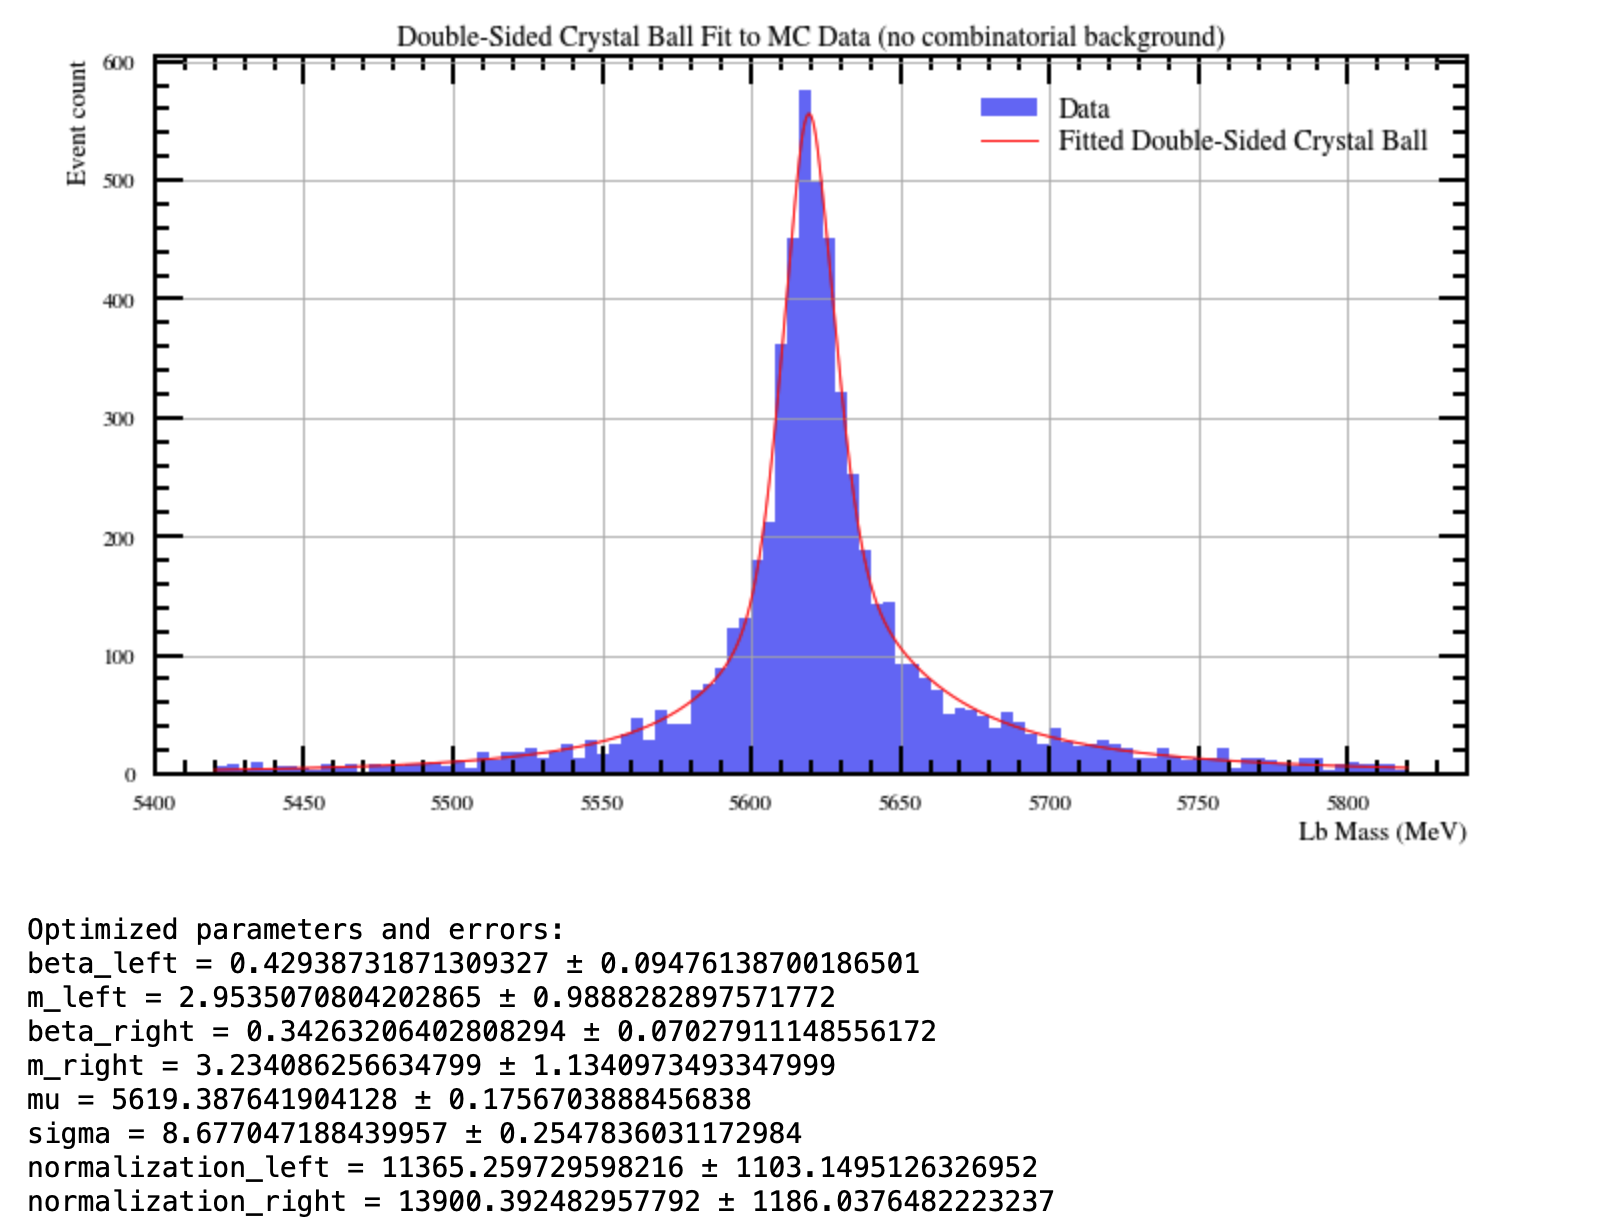

In [ ]:
#AntiParticle
def double_sided_crystal_ball(x, beta_L, m_L, beta_R, m_R, mu, sigma, normalization_L, normalization_R):
    left_side= normalization_L*crystal_ball_left(x, beta_L, m_L, mu, sigma)
    right_side= normalization_R*crystal_ball_right(x, beta_R, m_R, mu, sigma)


    return left_side+right_side


data = Lb_DTF_L0_JPs_PV_M_0_antiparticle.to_numpy()

#same n of bins in histogram and fitted data
min_x = 5420
max_x = 5820
n_bins = 100

# Create histogram
bin_contents, bin_edges = np.histogram(data, bins=n_bins, range=(min_x, max_x))
#bin_contents = how many data points in each bin
#bin_edges= bin_contents +1
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0


# Check if bin_contents is non-empty
if len(bin_contents) == 0:
    raise ValueError("The histogram is empty. Please check the input data and binning range.")


initial_guesses = [1,2,1,2,5620, 13, 4000,3000]

#curve_fit(f, xdata, ydata, p0, bounds= lower and upper bounds for parameter)
#popt = optimal values for parameters
#pcov = covariance matrix of parameter estimates
popt, pcov = curve_fit(double_sided_crystal_ball, bin_centers, bin_contents, p0=initial_guesses)
errors = np.sqrt(np.diag(pcov))
# Extract the optimal parameters
beta_L_opt, m_L_opt, beta_R_opt, m_R_opt, mu_opt, sigma_opt, normalization_L_opt, normalization_R_opt= popt

# Generate the fitted curve for plotting
x_fit = np.linspace(min_x, max_x, 5000)
y_fitted = double_sided_crystal_ball(x_fit, *popt)

# Plot the histogram of the data and the fitted curve
plt.figure(figsize=(10, 6))
plt.hist(data, bins=n_bins, range=(min_x, max_x), label='Data', alpha=0.6, color='blue')
plt.plot(x_fit, y_fitted, label="Fitted Double-Sided Crystal Ball", color="red", lw=1)
plt.title("Double-Sided Crystal Ball Fit to MC Data (no combinatorial background)")
plt.xlabel("Lb Mass (MeV)")
plt.ylabel("Event count")
plt.legend()
plt.grid(True)
plt.show()

#Optimal values for parameters
print("Optimized parameters and errors:")
print(f"beta_left = {beta_L_opt} ± {errors[0]}")
print(f"m_left = {m_L_opt} ± {errors[1]}")
print(f"beta_right = {beta_R_opt} ± {errors[2]}")
print(f"m_right = {m_R_opt} ± {errors[3]}")
print(f"mu = {mu_opt} ± {errors[4]}")
print(f"sigma = {sigma_opt} ± {errors[5]}")
print(f"normalization_left = {normalization_L_opt} ± {errors[6]}")
print(f"normalization_right = {normalization_R_opt} ± {errors[7]}")

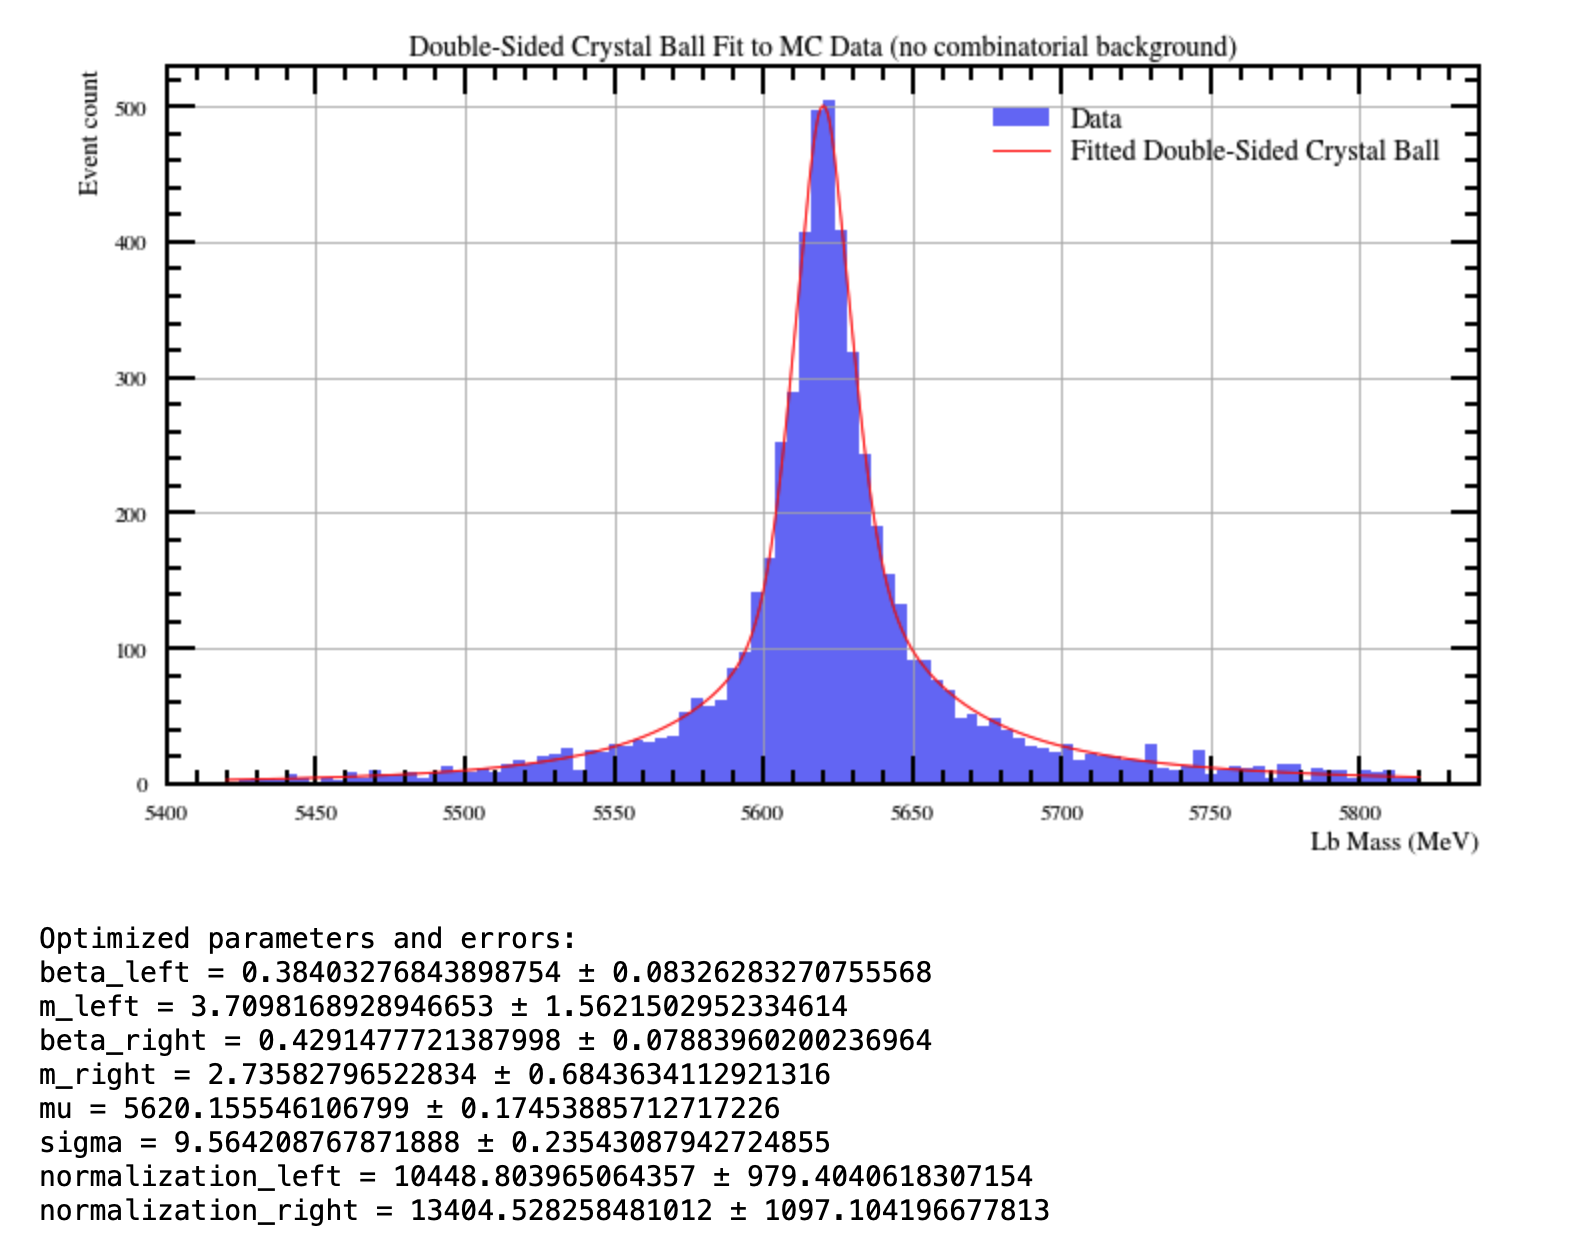

In [ ]:
#Gaussian method particle



def doubleGauss_with_norm(x, mean, stddev1, stddev2, norm1, norm2):
    return norm1 * norm.pdf(x, loc=mean, scale=stddev1) + norm2 * norm.pdf(x, loc=mean, scale=stddev2)


data = Lb_DTF_L0_JPs_PV_M_0_particle.to_numpy()

#same n of bins in histogram and fitted data
min_x = 5420
max_x = 5820
n_bins = 100

# Create histogram
bin_contents, bin_edges = np.histogram(data, bins=n_bins, range=(min_x, max_x))
#bin_contents = how many data points in each bin
#bin_edges= bin_contents +1
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0


# Check if bin_contents is non-empty
if len(bin_contents) == 0:
    raise ValueError("The histogram is empty. Please check the input data and binning range.")

initial_guesses = [5600,10,100,10000,10000]


#curve_fit(f, xdata, ydata, p0, bounds= lower and upper bounds for parameter)
#popt = optimal values for parameters
#pcov = covariance matrix of parameter estimates
popt, pcov = curve_fit(doubleGauss_with_norm, bin_centers, bin_contents, p0=initial_guesses)
errors = np.sqrt(np.diag(pcov))
# Extract the optimal parameters
mean_opt, stddev1_opt, stddev2_opt, norm1_opt, norm2_opt = popt

# Generate the fitted curve for plotting
x_fit = np.linspace(min_x, max_x, 5000)
y_fitted = doubleGauss_with_norm(x_fit, *popt)

# Plot the histogram of the data and the fitted curve
plt.figure(figsize=(10, 6))
plt.hist(data, bins=n_bins, range=(min_x, max_x), label='Data', alpha=0.6, color='blue')
plt.plot(x_fit, y_fitted, label="Fitted Double-Sided Crystal Ball", color="red", lw=1)
plt.title("Double-Sided Crystal Ball Fit to MC Data (no combinatorial background)")
plt.xlabel("Lb Mass (MeV)")
plt.ylabel("Event count")
plt.legend()
plt.grid(True)
plt.show()

#Optimal values for parameters
print("Optimized parameters and errors:")
print(f"mean_opt = {mean_opt} ± {errors[0]}")
print(f"stddev1_opt = {stddev1_opt} ± {errors[1]}")
print(f"stddev2_opt = {stddev2_opt} ± {errors[2]}")
print(f"norm1_opt = {norm1_opt} ± {errors[3]}")
print(f"norm2_opt = {norm2_opt} ± {errors[4]}")


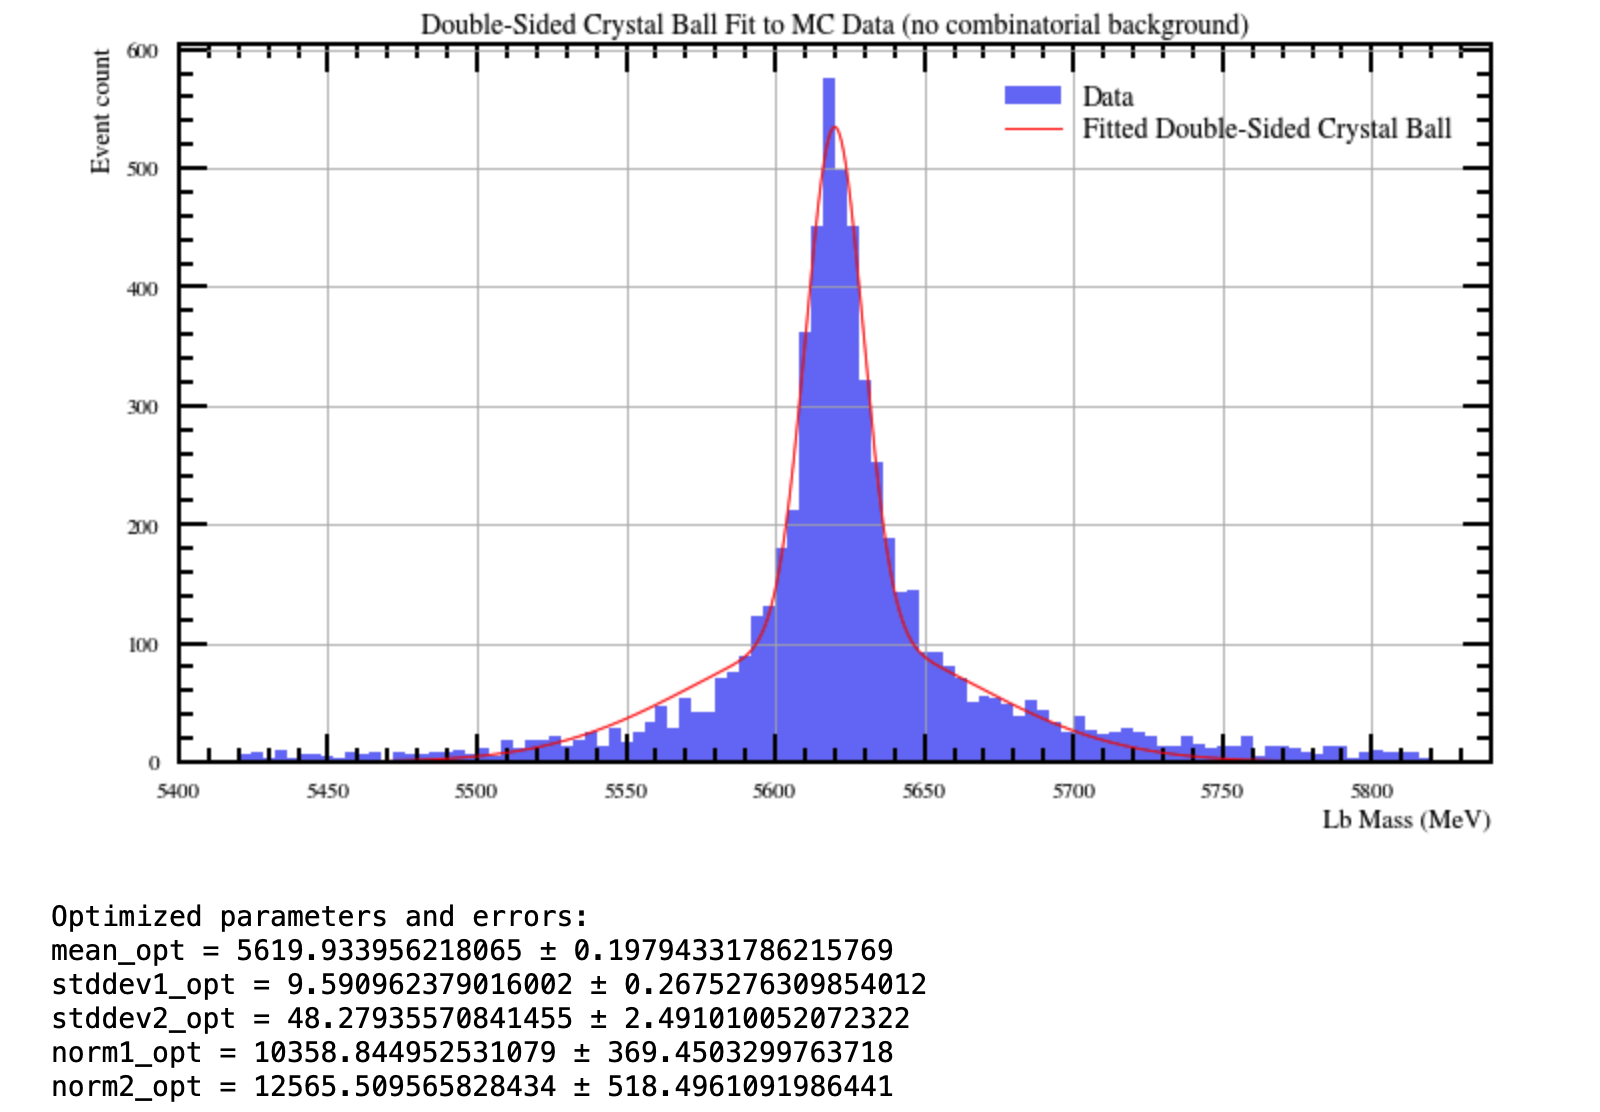

In [ ]:
#Gaussian method antiparticle



def doubleGauss_with_norm(x, mean, stddev1, stddev2, norm1, norm2):
    return norm1 * norm.pdf(x, loc=mean, scale=stddev1) + norm2 * norm.pdf(x, loc=mean, scale=stddev2)


data = Lb_DTF_L0_JPs_PV_M_0_antiparticle.to_numpy()

#same n of bins in histogram and fitted data
min_x = 5420
max_x = 5820
n_bins = 100

# Create histogram
bin_contents, bin_edges = np.histogram(data, bins=n_bins, range=(min_x, max_x))
#bin_contents = how many data points in each bin
#bin_edges= bin_contents +1
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0


# Check if bin_contents is non-empty
if len(bin_contents) == 0:
    raise ValueError("The histogram is empty. Please check the input data and binning range.")

initial_guesses = [5600,10,100,10000,10000]


#curve_fit(f, xdata, ydata, p0, bounds= lower and upper bounds for parameter)
#popt = optimal values for parameters
#pcov = covariance matrix of parameter estimates
popt, pcov = curve_fit(doubleGauss_with_norm, bin_centers, bin_contents, p0=initial_guesses)
errors = np.sqrt(np.diag(pcov))
# Extract the optimal parameters
mean_opt, stddev1_opt, stddev2_opt, norm1_opt, norm2_opt = popt

# Generate the fitted curve for plotting
x_fit = np.linspace(min_x, max_x, 5000)
y_fitted = doubleGauss_with_norm(x_fit, *popt)

# Plot the histogram of the data and the fitted curve
plt.figure(figsize=(10, 6))
plt.hist(data, bins=n_bins, range=(min_x, max_x), label='Data', alpha=0.6, color='blue')
plt.plot(x_fit, y_fitted, label="Fitted Double-Sided Crystal Ball", color="red", lw=1)
plt.title("Double-Sided Crystal Ball Fit to MC Data (no combinatorial background)")
plt.xlabel("Lb Mass (MeV)")
plt.ylabel("Event count")
plt.legend()
plt.grid(True)
plt.show()

#Optimal values for parameters
print("Optimized parameters and errors:")
print(f"mean_opt = {mean_opt} ± {errors[0]}")
print(f"stddev1_opt = {stddev1_opt} ± {errors[1]}")
print(f"stddev2_opt = {stddev2_opt} ± {errors[2]}")
print(f"norm1_opt = {norm1_opt} ± {errors[3]}")
print(f"norm2_opt = {norm2_opt} ± {errors[4]}")


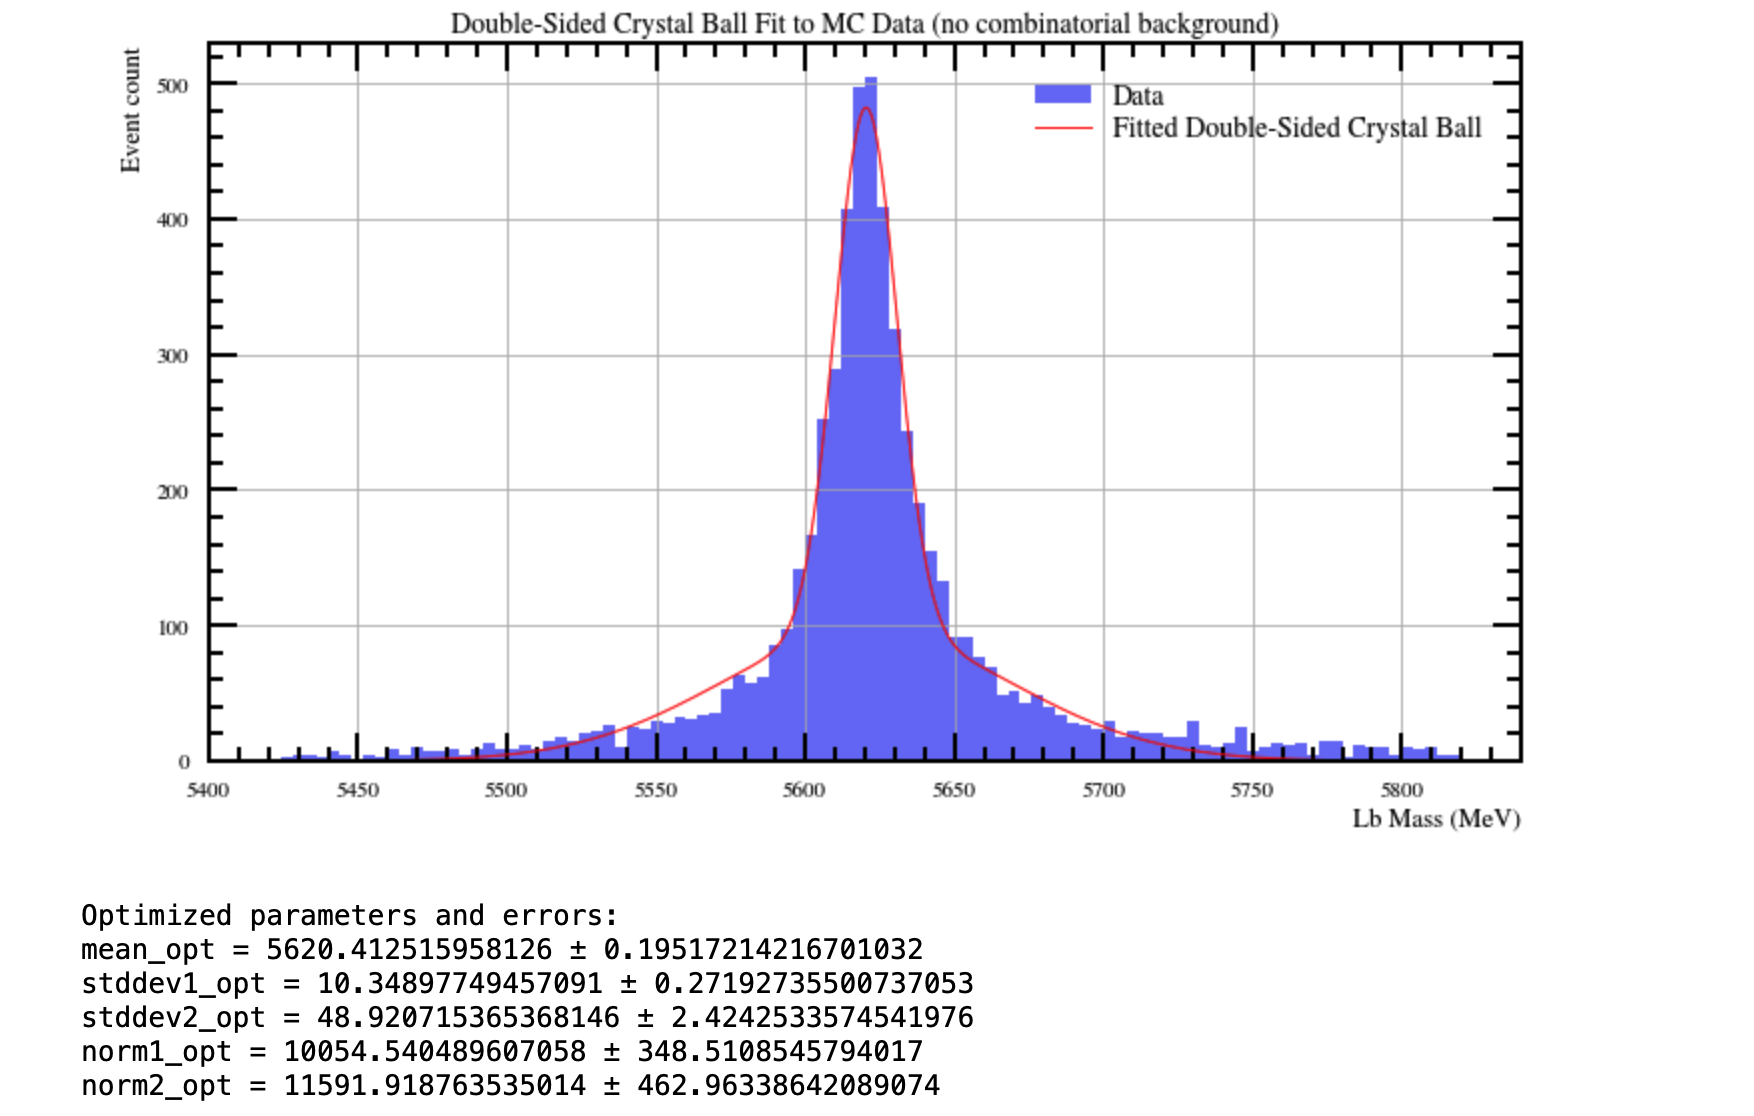